# House price estimation from visual and textual features

https://arxiv.org/pdf/1609.08399.pdf

https://github.com/emanhamed/Houses-dataset

In [1]:
%config Completer.use_jedi = False
from IPython.display import display, clear_output

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import cv2

In [11]:
from sklearn.preprocessing import LabelBinarizer, MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf

## 1. The Dataset

In [4]:
House_Path = '/Volumes/Data/Datasets/Houses Dataset/'
Image_Features = [ 'kitchen','bedroom', 'frontal','bathroom']

In [5]:
df = pd.read_csv(House_Path + 'HousesInfo.txt',sep=" ", header=None, 
                 names=["bedrooms", "bathrooms", "area", "zipcode", "price"])

df['tag']= df.index.values + 1

In [6]:
df.head()

bedrooms  bathrooms  area  zipcode   price  tag
0         4        4.0  4053    85255  869500    1
1         4        3.0  3343    36372  865200    2
2         3        4.0  3923    85266  889000    3
3         5        5.0  4022    85262  910000    4
4         3        4.0  4116    85266  971226    5

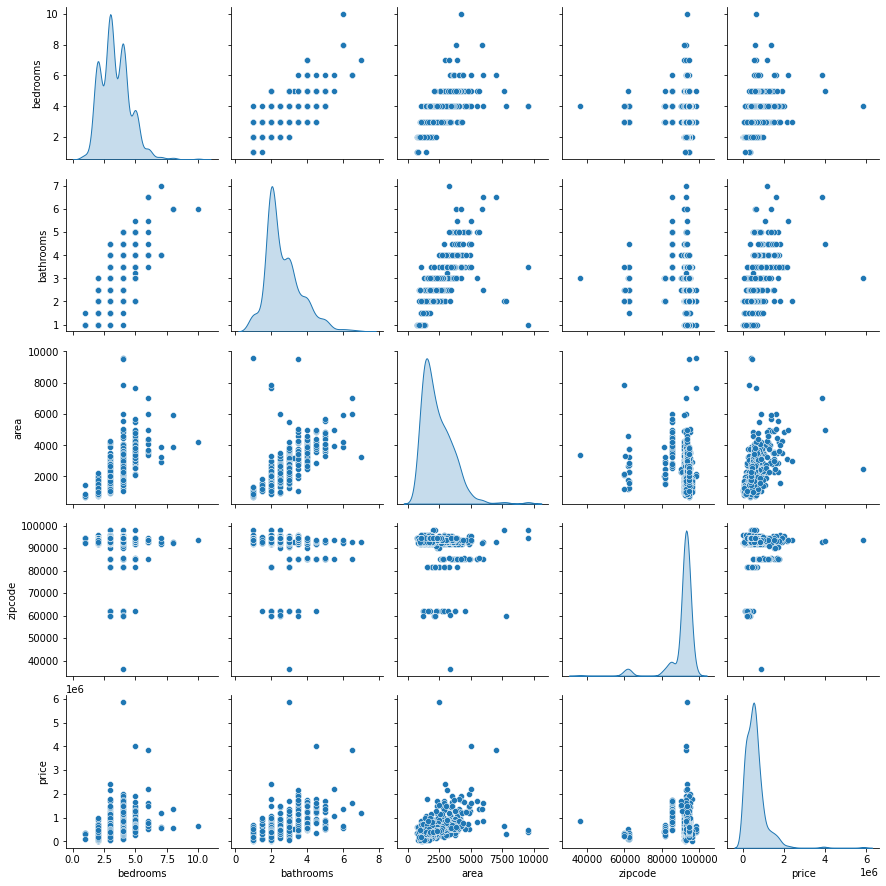

In [7]:
sns.pairplot(df[['bedrooms', 'bathrooms', 'area', 'zipcode','price']], diag_kind='kde');

In [8]:
## The dataset is unbalanced with the zipcode feature
zipcodes = df["zipcode"].value_counts().keys().tolist()
counts = df["zipcode"].value_counts().tolist()

for (zipcode, count) in zip(zipcodes, counts):
    if count < 4:
        idxs = df[df["zipcode"] == zipcode].index
        df.drop(idxs, inplace=True)
        
df = df.reset_index(drop=True)    

In [9]:
target_min = df["price"].min()
target_max = df["price"].max()
df['target'] = (df["price"] - target_min)/(target_max-target_min)

In [12]:
(train, test) = train_test_split( df, test_size = 0.15, random_state=42)

One-hot encodeing the zipcode feature and normalize the three others

In [15]:
zipBinarizer = LabelBinarizer().fit(df["zipcode"])
trainCategorical = zipBinarizer.transform(train["zipcode"])
testCategorical = zipBinarizer.transform(test["zipcode"])

scaler_features = MinMaxScaler()
trainContinuous = scaler_features.fit_transform( train[["bedrooms", "bathrooms", "area"]] )
testContinuous = scaler_features.transform( test[["bedrooms", "bathrooms", "area"]] )

X_train = np.hstack([trainCategorical, trainContinuous])
X_test  = np.hstack([testCategorical, testContinuous])

y_train = train["target"] 
y_test  = test["target"] 

# 2. Regression Model
<img src='images/regression.png'/>

In [16]:
def model_tablulated(n_features, regress = False):
    
    model = tf.keras.models.Sequential([ 
        tf.keras.layers.Dense( 8, input_dim = n_features, activation="relu"),
        tf.keras.layers.Dense( 4, activation="relu"),
    ], name='tablulated')
     
    if regress:
        model.add( tf.keras.layers.Dense(1, activation="linear"))

        opt = tf.keras.optimizers.Adam(lr=1e-3) #decay=1e-3 / 200

        model.compile(loss="mean_squared_error", optimizer=opt )
    
        model.summary()    
    return model
    

In [17]:
model_reg = model_tablulated(X_train.shape[1], regress = True)

Model: "tablulated"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 192       
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 233
Trainable params: 233
Non-trainable params: 0
_________________________________________________________________


In [18]:
h_reg = model_reg.fit(x=X_train, y=y_train, 
                  validation_data=(X_test, y_test), 
                  epochs=100, batch_size=8, verbose=0)

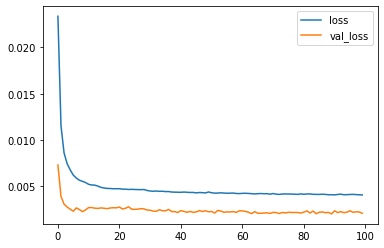

In [19]:
df_reg = pd.DataFrame(h_reg.history)
df_reg.plot();

In [20]:
y_pred = model_reg.predict(X_test)
df_y = pd.DataFrame({'true':y_test.squeeze(),'predicted':y_pred.squeeze()})

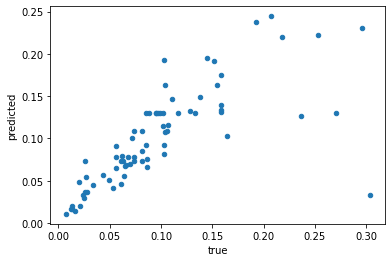

In [21]:
df_y.plot(kind ='scatter', x='true', y='predicted');

## 3. Featured images

In [76]:
def single_feature(df_sample, feature_name, size, bw = False):     
    
    fileList = [os.path.join(House_Path, "{}_{}.jpg".format(int(i), feature_name))  for i in df_sample['tag']]
    images = []    
    
    for file in fileList:
        image = cv2.imread(file)
        w,h,c = image.shape

        if w > h:
            image = cv2.resize(image, (size, int(size*w/h) ), interpolation = cv2.INTER_AREA)
            mid = ( image.shape[0] - size)//2
            image = image[ mid: mid + size :,]    
        else:
            image = cv2.resize(image, (int(size*h/w), size ), interpolation = cv2.INTER_AREA)
            mid = ( image.shape[1] - size)//2
            image = image[:, mid: mid + size ]
        images.append(image)

    return np.asarray(images)/255.

def group_feature(df_sample, size, bw = False):

    kitchen  = single_feature(df_sample, 'kitchen', size, bw)
    bedroom  = single_feature(df_sample, 'bedroom', size, bw)
    frontal  = single_feature(df_sample, 'frontal', size, bw)
    bathroom = single_feature(df_sample, 'bathroom', size, bw)

    images = list()
    for n in range( len( df_sample.index.values) ):
        image = np.zeros( (size*2, size*2, 3) )
        image[0:size, 0:size]   = kitchen[n]
        image[0:size, size:size*2] = bedroom[n]
        image[size:size*2, size:size*2] = frontal[n]
        image[size:size*2, 0:size]= bathroom[n]    

        images.append(image)
    return np.asarray(images)  


In [77]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, batch_size=32, img_size = 128, shuffle=True, bw = False):
        self.batch_size = batch_size
        self.img_size = img_size
        self.df = df
        self.indices = self.df.index.tolist()
        self.shuffle = shuffle
        self.feature ='frontal'
        self.bw = bw
        self.on_epoch_end()

    def __len__(self):
        return len(self.indices) // self.batch_size

    def __getitem__(self, index):
        index = self.index[index * self.batch_size:(index + 1) * self.batch_size]
        batch = [self.indices[k] for k in index]       
        X, y = self.__get_data(batch)
        return X, y
    
    def get_shape(self):
        if self.feature == 'grouped':
            return (self.img_size*2,self.img_size*2, 3)
        else:            
            return (self.img_size,self.img_size, 3)   
           
    def set_feature(self, feature):
        self.feature = feature
        
    def set_size(self, img_size):
        self.img_size = img_size
                
    def on_epoch_end(self):
        self.index = np.arange(len(self.indices))
        if self.shuffle == True:
            np.random.shuffle(self.index)
        
    def __get_data(self, batch):
        dfb = self.df.loc[batch]
        
        if self.feature == 'grouped':
            images = group_feature(dfb, self.img_size, self.bw)          
        else:            
            images = single_feature(dfb, self.feature, self.img_size, self.bw)  

        labels =  dfb['target'].values
        return images, labels    

In [78]:
train_gen = DataGenerator(train, batch_size=8, img_size = 128,  shuffle=True)
test_gen  = DataGenerator(test, batch_size=8, img_size = 128,  shuffle=False)

In [ ]:
def display_sample(df, n_houses):   
    plt.figure( figsize=(15, 15))

    dr  = df.sample(n=n_houses)    
    idx = 1
    for index, row in dr.iterrows():
        for feature in Image_Features:
            ax     = plt.subplot(n_houses, 4, idx)     
            fname = os.path.join(House_Path, "{}_{}.jpg".format( int(row['tag']), feature ))
            im = cv2.imread( fname )    
            plt.imshow( cv2.cvtColor(im, cv2.COLOR_BGR2RGB))        
            label = "{}  ${}".format(feature, row['price'])     
            ax.title.set_text(label)
            ax.set_xticks([])
            ax.set_yticks([])       
            idx = idx +1

    plt.show()  
 
def diplay_target_images( images, y_pred, y_true, title, sublist):  
    plt.figure( figsize=(15, 15))   
    idx  = 1       
    cols = int(np.sqrt(len( sublist ))) + 1    
    plt.title(title )
    tratio = target_max - target_min
    
    for n  in sublist:
        ax = plt.subplot( cols, cols, idx)  
        plt.imshow( images[n])    
        label = "pred:${}\n true: ${}".format( np.round(y_pred[n] * tratio + target_min, 0) , 
                                               np.round(y_true[n] * tratio + target_min, 0))  
        ax.title.set_text(label)
        ax.set_xticks([])
        ax.set_yticks([])       
        idx = idx +1
    plt.show()


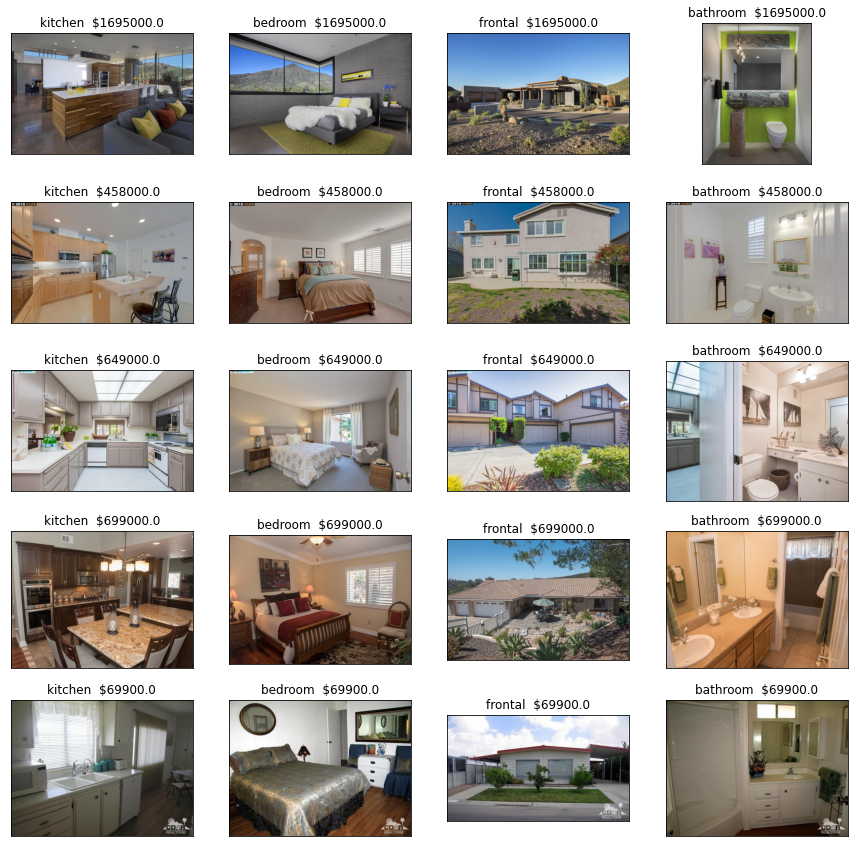

In [29]:
display_sample(df, 5)

# 4. Price prediction based on single featured image

<img src='images/SingleFeature.png' />

In [30]:
def model_single_image(input_shape, filters=(16, 32, 64), regress=False):

    inputs  = tf.keras.layers.Input( shape= input_shape )
    x = inputs
       
    for (i, f) in enumerate(filters):
        x = tf.keras.layers.Conv2D(f, (3, 3), padding="same", activation="relu")(x)
        x = tf.keras.layers.BatchNormalization(axis=-1)(x)
        x = tf.keras.layers.MaxPooling2D((2, 2))(x)
        
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(16, activation="relu")(x)
    x = tf.keras.layers.BatchNormalization(axis=-1)(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    
    x = tf.keras.layers.Dense(4, activation="relu")(x)

    
    if regress:
        x = tf.keras.layers. Dense(1, activation="linear")(x)
        model = tf.keras.models.Model(inputs, x)
        
        opt = tf.keras.optimizers.Adam(lr=1e-3)
        model.compile(loss="mean_squared_error", optimizer=opt )
        model.summary()    
        
    else:
        model = tf.keras.models.Model(inputs, x, name='CNN Single Image')
    
    
    return model     

In [31]:
model_frontal = model_single_image( train_gen.get_shape() , regress = True)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 16)      448       
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0     

In [29]:
#tf.keras.utils.plot_model(model_frontal, to_file='SingleFeature.png', show_shapes=True)

In [32]:
class CustomCallbacks( tf.keras.callbacks.Callback ):
    def __init__(self, level=1):
        super(CustomCallbacks, self).__init__()
        self.level = level
        
    def on_epoch_end(self, epoch, logs={}):        
        if(logs.get('loss')< self.level ):
            print("\n {}% loss reached".format(self.level))
            self.model.stop_training = True


In [33]:
h_frontal = model_frontal.fit(train_gen,
                    steps_per_epoch=len(train)//8,
                    epochs=50,
                    validation_data=test_gen,
                    #callbacks=[CustomCallbacks(0.05)],
                    validation_steps=len(test)//8)

Epoch 1/50
52/52 [==============================] - 13s 232ms/step - loss: 0.7937 - val_loss: 1.2466
Epoch 2/50
52/52 [==============================] - 9s 172ms/step - loss: 0.3914 - val_loss: 7.9595
Epoch 3/50
52/52 [==============================] - 9s 177ms/step - loss: 0.2955 - val_loss: 11.9389
Epoch 4/50
52/52 [==============================] - 8s 160ms/step - loss: 0.2400 - val_loss: 7.9527
Epoch 5/50
52/52 [==============================] - 9s 168ms/step - loss: 0.1716 - val_loss: 6.7690
Epoch 6/50
52/52 [==============================] - 9s 171ms/step - loss: 0.1442 - val_loss: 3.7674
Epoch 7/50
52/52 [==============================] - 9s 168ms/step - loss: 0.0918 - val_loss: 2.1802
Epoch 8/50
52/52 [==============================] - 9s 164ms/step - loss: 0.1168 - val_loss: 0.2644
Epoch 9/50
52/52 [==============================] - 9s 171ms/step - loss: 0.0927 - val_loss: 0.0538
Epoch 10/50
52/52 [==============================] - 9s 168ms/step - loss: 0.0535 - val_loss: 0.07

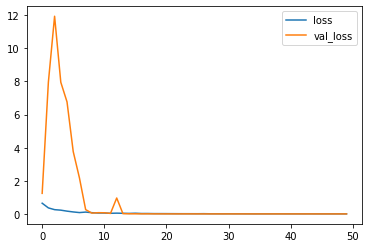

In [34]:
df_frontal = pd.DataFrame(h_frontal.history)
df_frontal.plot();

In [37]:
images = single_feature(test, 'frontal', 128)
y_true = test['target'].values

In [52]:
y_pred = model_frontal.predict(images)
y_diff = np.abs(y_pred.squeeze() - y_true.squeeze())

In [62]:
th0   = 0.01
nid   = np.where (y_diff < th0 )[0]
title = 'House with error diffence less than {}%'.format(th0*100) 

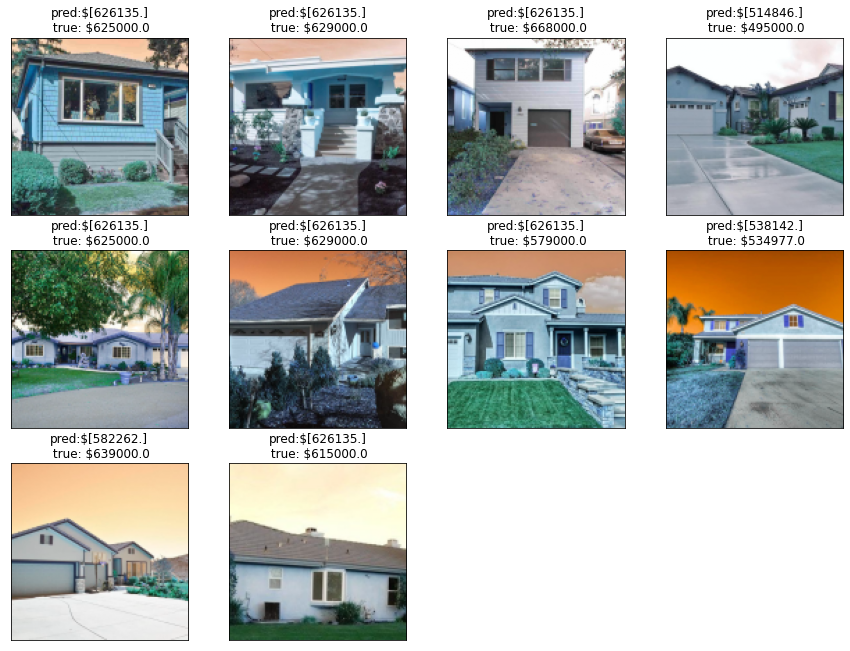

In [64]:
diplay_target_images( images, y_pred, y_true, title, nid) 

In [70]:
th1   = 0.2
nid   = np.where (y_diff > th1 )[0]
title = 'House with error diffence greater than {}%'.format(th1*100) 

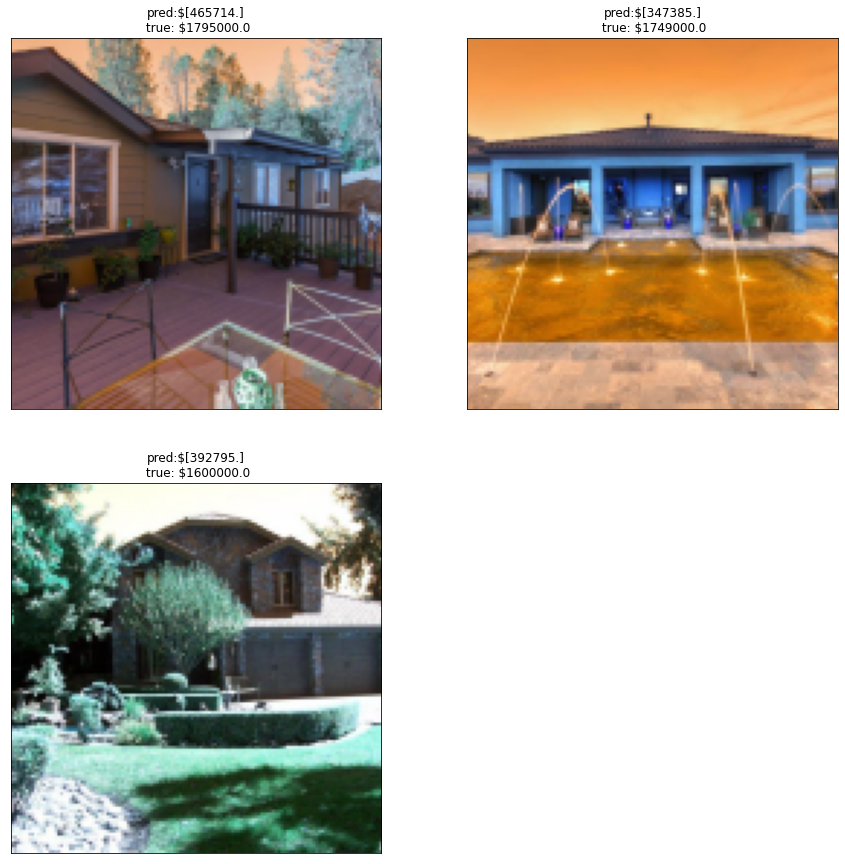

In [71]:
diplay_target_images( images, y_pred, y_true, title, nid) 

# 5. Price prediction based on mergd featured images

In [79]:
train_gen.set_feature('grouped')
test_gen.set_feature('grouped')
train_gen.set_size(100)
test_gen.set_size(100)

In [80]:
model_merged = model_single_image( train_gen.get_shape() , regress = True)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 200, 200, 16)      448       
_________________________________________________________________
batch_normalization_8 (Batch (None, 200, 200, 16)      64        
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 100, 100, 16)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 100, 100, 32)      4640      
_________________________________________________________________
batch_normalization_9 (Batch (None, 100, 100, 32)      128       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 50, 50, 32)        0   

In [81]:
h_merged = model_merged.fit(train_gen,
                    steps_per_epoch=len(train)//8,
                    epochs=50,
                    validation_data=test_gen,
                    #callbacks=[CustomCallbacks(0.05)],
                    validation_steps=len(test)//8)

Epoch 1/50
52/52 [==============================] - 48s 907ms/step - loss: 0.7918 - val_loss: 1.3180
Epoch 2/50
52/52 [==============================] - 45s 874ms/step - loss: 0.2331 - val_loss: 7.2825
Epoch 3/50
52/52 [==============================] - 47s 898ms/step - loss: 0.1599 - val_loss: 13.8404
Epoch 4/50
52/52 [==============================] - 47s 902ms/step - loss: 0.0981 - val_loss: 9.2349
Epoch 5/50
52/52 [==============================] - 47s 912ms/step - loss: 0.0356 - val_loss: 3.0930
Epoch 6/50
52/52 [==============================] - 45s 874ms/step - loss: 0.0476 - val_loss: 1.3049
Epoch 7/50
52/52 [==============================] - 49s 953ms/step - loss: 0.0302 - val_loss: 0.7318
Epoch 8/50
52/52 [==============================] - 56s 1s/step - loss: 0.0343 - val_loss: 0.3717
Epoch 9/50
52/52 [==============================] - 52s 994ms/step - loss: 0.0227 - val_loss: 0.0301
Epoch 10/50
52/52 [==============================] - 56s 1s/step - loss: 0.0200 - val_loss: 1

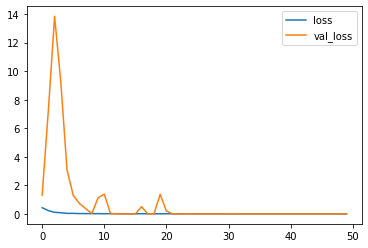

In [82]:
df_merged = pd.DataFrame(h_merged.history)
df_merged.plot();

In [87]:
images = group_feature(test, 100)
y_true = test['target'].values
y_pred = model_merged.predict(images)
y_diff = np.abs(y_pred.squeeze() - y_true.squeeze())

In [90]:
th0   = 0.005
nid   = np.where (y_diff < th0 )[0]
title = 'House with error diffence less than {}%'.format(th0*100) 

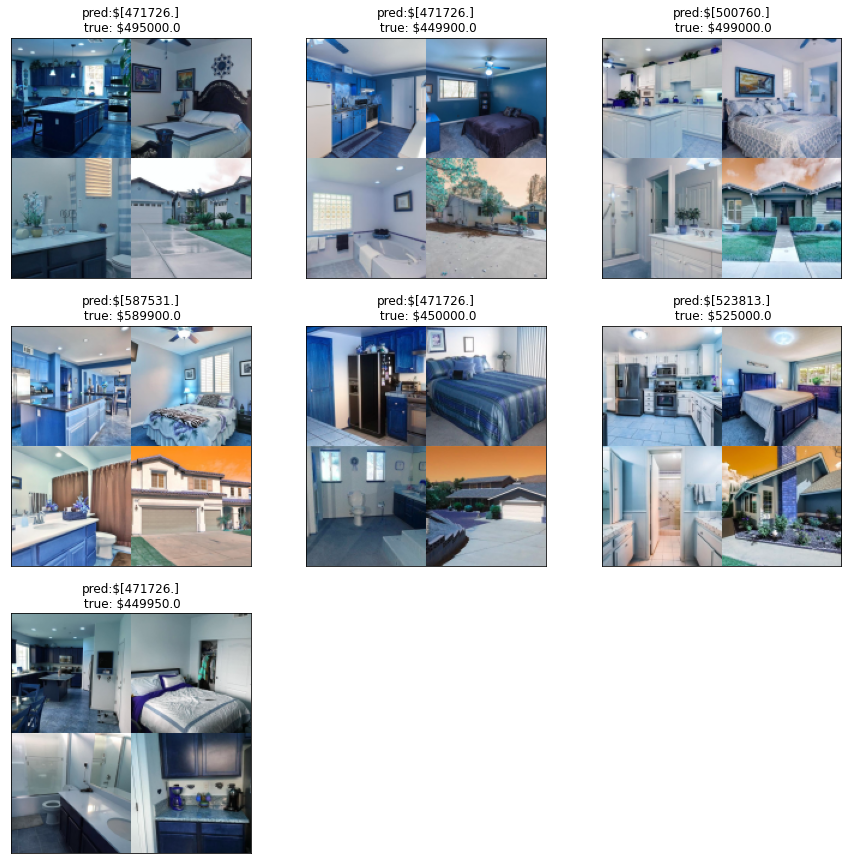

In [92]:
diplay_target_images( images, y_pred, y_true, title, nid) 

In [102]:
th1   = 0.15
nid   = np.where (y_diff > th1 )[0]
title = 'House with error diffence greater than {}%'.format(th1*100) 

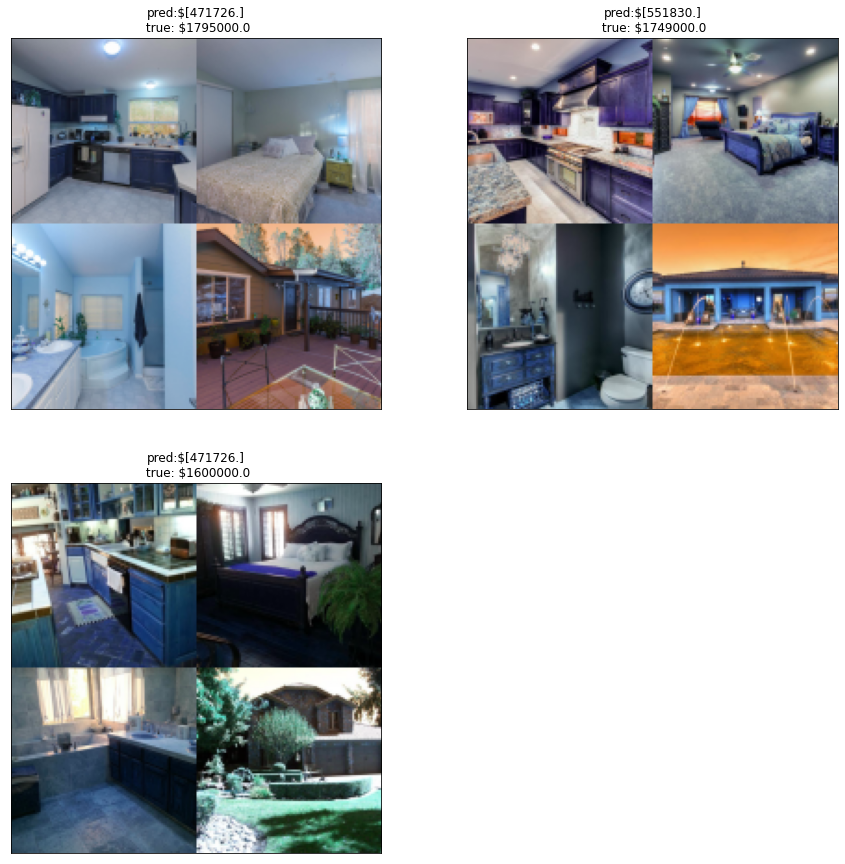

In [104]:
diplay_target_images( images, y_pred, y_true, title, nid) 

## 3. Mixed Model


<img src='images/modelC.png'/>


In [105]:
XI_train = group_feature(train, 100)
XI_test  = group_feature(test , 100)

In [106]:
def model_mixed(model_A, model_B):
    combinedInput = tf.keras.layers.concatenate([model_A.output, model_B.output])
    x = tf.keras.layers.Dense(4, activation="relu")(combinedInput)
    x = tf.keras.layers.Dense(1, activation="linear")(x)
    
    model = tf.keras.models.Model(inputs=[model_A.input, model_B.input], outputs=x)
    
    opt = tf.keras.optimizers.Adam(lr=1e-3)

    model.compile(loss="mse",optimizer=opt )
    
    model.summary()    
    return model

In [108]:
model_A = model_tablulated(X_train.shape[1])
model_B = model_single_image( (XI_train.shape[1], XI_train.shape[2], XI_train.shape[3]))
model_C = model_mixed(model_A, model_B)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 200, 200, 16) 448         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 200, 200, 16) 64          conv2d_9[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_9 (MaxPooling2D)  (None, 100, 100, 16) 0           batch_normalization_12[0][0]     
____________________________________________________________________________________________

In [110]:
#tf.keras.utils.plot_model(model_C, to_file='model_C.png', show_shapes=True)

In [111]:
h_c = model_C.fit( x=[X_train, XI_train], y=y_train,
        validation_data=([X_test, XI_test], y_test),
        epochs=50, batch_size=8, verbose=1)
        #callbacks=[CustomCallbacks(0.01)])

Epoch 1/50
53/53 [==============================] - 15s 268ms/step - loss: 0.2925 - val_loss: 0.0046
Epoch 2/50
53/53 [==============================] - 14s 258ms/step - loss: 0.0743 - val_loss: 0.0246
Epoch 3/50
53/53 [==============================] - 13s 253ms/step - loss: 0.0468 - val_loss: 0.0417
Epoch 4/50
53/53 [==============================] - 13s 248ms/step - loss: 0.0333 - val_loss: 0.0301
Epoch 5/50
53/53 [==============================] - 14s 256ms/step - loss: 0.0293 - val_loss: 0.3941
Epoch 6/50
53/53 [==============================] - 14s 272ms/step - loss: 0.0175 - val_loss: 0.6096
Epoch 7/50
53/53 [==============================] - 14s 264ms/step - loss: 0.0204 - val_loss: 0.8530
Epoch 8/50
53/53 [==============================] - 13s 252ms/step - loss: 0.0161 - val_loss: 0.6322
Epoch 9/50
53/53 [==============================] - 13s 248ms/step - loss: 0.0071 - val_loss: 0.4576
Epoch 10/50
53/53 [==============================] - 14s 254ms/step - loss: 0.0140 - val_lo

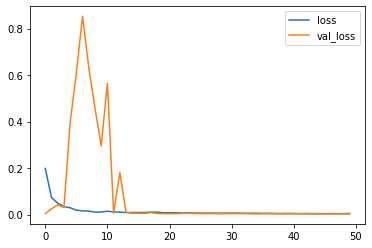

In [112]:
df_c = pd.DataFrame(h_c.history)
df_c.plot();